# JupyLSQEGen

Notebook Licence: [https://creativecommons.org/licenses/by/4.0/](https://creativecommons.org/licenses/by/4.0/)

Table of Contents:
* [Python Concepts Primer](#Python-Concepts-Primer)
* [Differential Cross Section for the Hard Scatter](#Differential-Cross-Section-for-the-Hard-Scatter)
* [Kinematics Calculation](#Observable-Kinematics)
* [The Cross Section for the Hard Scatter](#The-Cross-Section-for-the-Hard-Scatter)
* [Aside: Monte Carlo Sampling](#Aside:-Monte-Carlo-Sampling)
* The Free Nucleon Event Generator
* Putting the Nucleon in Nucleus
* Some Simple Nuclear Effects
* Neutrino Energy Distributions


## Python Concepts Primer

If you are new to numpy or python classes, the minimal set of features that we will use are demonstrated in the collapsed cells below.

### `numpy`

`numpy` is a foundational library in the python ecosystem for working with numbers. It is especially useful for expressing mathematic operations to be performed on large sets of numbers without explicit looping in python, which is comparatively slow. It is one of the building blocks of any performant library code, and while performance will not be a strict concern of this course, it will still be a useful library to use a few core concepts from.

For the official `numpy` quickstart documentation if you'd like to learn more, go here: [https://numpy.org/doc/stable/user/quickstart.html](https://numpy.org/doc/stable/user/quickstart.html).

#### `ndarrays`, array creation, and `linspace`

`numpy` is mostly concerned with operations over arrays of numbers. The foundational class is `ndarray`, which is a multidimensional rectangular array of arbitrary dimensionality and size. We will only be using 1d arrays in this course, but most of the concepts trivially generalise. 

**A note on arrays and matrices:** It is worth noting that arrays do not automatically perform matrix algebra, for that you need to explicitly use matrix methods or special operators. We will not use numpy for linear algebra in this course, so this detail is just for interest.

We can use `numpy.array` to construct ndarrays from python lists, as below.

In [1]:
import numpy as np
myarr = np.array([i for i in range(10)])
print(myarr)

[0 1 2 3 4 5 6 7 8 9]


We can then perform mathematical operatons on the whole list at once, and these operations are applied element-wise, side-stepping the need for explicit looping in many constructs. This will be especially useful in the construction of an event generator where many operations are *embaressingly* parallelisable. Again, performance is not a core focus of this cource, but using concepts that enable high expressivity and reduce the complexity of the code will help.

In [2]:
myarr2 = myarr * 2
print("myarr2: %s" % myarr2)

myarrsq = myarr * myarr
print("myarrsq: %s" % myarrsq)

myarr2: [ 0  2  4  6  8 10 12 14 16 18]
myarrsq: [ 0  1  4  9 16 25 36 49 64 81]


Some python builtins are overriden for numpy arrays, but some are not. Important examples are `pow` and `sqrt`, which we need to use numpy versions of. However, if these versions are passed a python builtin scalar, they operate as expected and so code can be easily written that works either on numbers or on numpy arrays.

In [3]:
myscalar = 5

myscalarsqrt = np.sqrt(myscalar)
print("myscalarsqrt: %s" % myscalarsqrt)

myscalarpow3 = np.power(myscalar,3)
print("myarrpow3: %s" % myscalarpow3)

myarrsqrt = np.sqrt(myarr)
print("myarrsqrt: %s" % myarrsqrt)

myarrpow3 = np.power(myarr,3)
print("myarrpow3: %s" % myarrpow3)

myscalarsqrt: 2.23606797749979
myarrpow3: 125
myarrsqrt: [0.         1.         1.41421356 1.73205081 2.         2.23606798
 2.44948974 2.64575131 2.82842712 3.        ]
myarrpow3: [  0   1   8  27  64 125 216 343 512 729]


A very useful method for creating arrays is `numpy.linspace(start, stop, N)`, this creates an array `N` long with entries linearly spaced between `start` and `stop`. Below we can see a small glimpse of the power and expressivity that numpy provides by plotting $\sin{x}$.

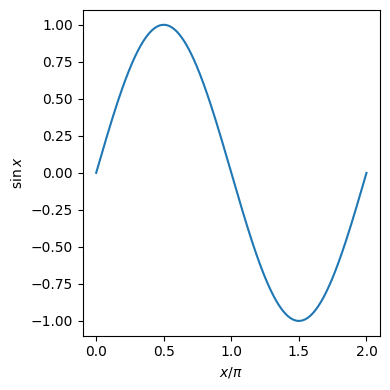

In [4]:
from math import pi
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (4,4)
plt.rcParams["figure.autolayout"] = True
plt.rcParams["hist.bins"] = 100

xs = np.linspace(0,2*pi,1000)

plt.plot(xs / pi, np.sin(xs))
plt.ylabel(r"$\sin{x}$")
plt.xlabel(r"$x / \pi$")
plt.show()

#### Broadcasting

#### Indexing and Mask Arrays

We will not be using much advanced `numpy` indexing techniques and so I recommend consulting the official documentation if you'd like to know more about slicing and striding `numpy` `ndarray`s: [https://numpy.org/doc/stable/user/basics.indexing.html](https://numpy.org/doc/stable/user/basics.indexing.html)

We will make use of one advanced indexing technique, and that is the use of masks. Masks are boolean `ndarray`s which are used to sub-select elements to engage in assignment or computation. This can be a very useful technique when writing numpy functions that may produce some non-physical or invalid elements that you would like to avoid using in ongoing computation. Since we are not driving the computational loop over elements explicitly, we cannot use conditionals in the way that we might naively expect.

See the example below where some previous calculation produces a value for $\cos{\theta}$. We would like to calculate theta, but the range of the previous calculation is greater than the domain of $\cos$.

In [5]:
from scipy.stats import uniform

#for this example use some random numbers as a stand-in
#  for previous calculations
costheta = uniform.rvs(0,2, 10)
np.arccos(costheta)

/tmp/ipykernel_390424/2122919563.py:6: RuntimeWarning: invalid value encountered in arccos
  np.arccos(costheta)


array([       nan, 0.66587133, 0.31143831,        nan,        nan,
              nan, 0.69212294,        nan,        nan,        nan])

It is very likely that the above causes a unsightly warning messages and `nan` in the output array.

We can build a *mask* of valid values on which to operate, which avoids warnings and errors and only performs the calculations that are valid to perform.

In [6]:
np.arccos(costheta[costheta <= 1])

array([0.66587133, 0.31143831, 0.69212294])

Often, with numpy, we want to perform concurent operations on a vector of data of fixed size. Since the return value of the masked operation is *smaller* than the input value because the operation is only performed on the subset of valid elements, this can make things fiddly. Luckily `numpy` has a solution for this, and it comes from masked assignment, as below. 

In [7]:
# construct the output array with the same shape as the input array
theta = np.zeros_like(costheta)
valid_mask = costheta <= 1
theta[valid_mask] = np.arccos(costheta[valid_mask])
print(theta)

[0.         0.66587133 0.31143831 0.         0.         0.
 0.69212294 0.         0.         0.        ]


We can use the `~` operator to logically invert the mask, which can be useful to assign dummy or magic values to invalid elements. 

In [8]:
theta[~valid_mask] = 0xdeadbeef
print(theta)

[3.73592856e+09 6.65871334e-01 3.11438314e-01 3.73592856e+09
 3.73592856e+09 3.73592856e+09 6.92122941e-01 3.73592856e+09
 3.73592856e+09 3.73592856e+09]


**N.B.** The above is actually a bad practical example of using magic values because values of theta are likely to be used with trigonometric functions with $x\in\mathcal{R}$ support which makes it very easy to forget that you are keeping track of some invalid values in your calculation. 

### Python Classes

The implementation we will build is not object-oriented (OO), but we will use classes for grouping similar data together, like C structs. The only required knowledge will be how to define a class with a constructor, how to instantiate an instance of that class,  understanding the `self` parameter. We will also use some very minimal inheritance to allow us to add features to existing classes, as a result we will need to known how to define subclasses (inheritance), and call superclass (base class) methods. This basic usage is shown below.

In [9]:
#classes in python need to 'subclass' a 'super' class. The most basic super
#  class is the builtin object type.
class Dummy(object):
    #__init__ is a magic method that is used as the constructor for the class
    #  the first parameter is an explicit handle to the instance of the class
    #  for a constructor this parameter is a brand new 'empty' class instance.
    #  convetionally this parameter is always named 'self' and it is a very
    #  good idea to stick to this convention, even if it is not enforced by
    #  the language.
    def __init__(self, val):
        #add attributes to the class through assignment, attributes set in a
        #  constructor can be considered similar to data members in OO languages
        self.myattr = val

#make an Dummy instance
mydummy1 = Dummy(1)
mydummy2 = Dummy(2)

#attributes assigned in the constructor are instance-specific
print("mydummy1.myattr = %s" % mydummy1.myattr)
print("mydummy2.myattr = %s" % mydummy2.myattr)

mydummy1.myattr = 1
mydummy2.myattr = 2


In [10]:
#here we declare SubDummy to be a subclass of Dummy
class SubDummy(Dummy):
    def __init__(self, val):
        #pass our argument onto the superclass constructor, 
        #  which we call manually
        super().__init__(val)

        #we can use attributes of the super class
        self.mysubattr = self.myattr * 2

mysubdummy1 = SubDummy(1)
print("mysubdummy1.myattr = %s, mysubdummy1.mysubattr = %s" % (mysubdummy1.myattr, mysubdummy1.mysubattr))

mysubdummy1.myattr = 1, mysubdummy1.mysubattr = 2


Thats all of the python OO that we will be relying on for this course!

## Differential Cross Section for the Hard Scatter

The first step of building a generator is working out what model to implement. We aren't writing a model here, we're just trying to build a generator, so lets base it upon a relatively simple model of a relatively simple interaction.

We will implement the Llewellyn Smith CCQE model from the seminal paper [*Neutrino Reactions at Accelerator Energies.*](https://www.sciencedirect.com/science/article/pii/0370157372900105).

Starting on page 300 (page 40 of the document), $\S$ 3.3 Quasi-Elastic Neutrino Scattering ($\Delta Y = 0$). Our first goal is to implement the differential cross section, $d\sigma/d\left|q^2\right|$ (page 301 eqn. 3.18).

Throughout, we will use the very common $Q^2 = -q^2$ to avoid carrying around needless minus signs due to our choice of metric. Internally some functions still use $q^2$, rather than $Q^2$, but we will make all interfaces take positive parameters for simplicity and consistency.

It is useful to define some constants and units that we will use throughout the model implementation. If you were building a real generator, it is a good idea to use a proper complete system of units, but for this, it will be okay to just define the ones that we will use.

In [11]:
# Constants
## Units
fm = 5.068 # GeV^-1
cm2 = fm * fm * 1E26 # GeV^-2
pb = 1E-36 * cm2

## Physical Constants
GF = 1.1663787e-5  # Fermi coupling constant in GeV^-2
cos_theta_C = 0.97425  # Cosine of the Cabibbo angle
eta = 3.71

## Particle Masses
m_p = 0.938272  # Proton mass in GeV/c^2
m_n = 0.939565  # Neutron mass in GeV/c^2
m_mu = 0.105658  # Muon mass in GeV/c^2
m_e = 0.000511  # electron mass in GeV/c^2
m_pi = 0.1396  # pion mass in GeV/c^2

## Model Parameters
M_A_GeV = 1.03
M_V_GeV = 0.73
g_A = -1.23

### Nucleon Form Factors

We need to be able to calculate the weak nucleon form factors, which are functions of the four-momentum transfer squared, $q^2$. 
At the time the Llewellyn Smith reference was written our knowledge of the weak form factors was poor and so the sophisticated data-driven parameterisations that we often see today were not available. Here, that works in our favor, as we can use simple implementations for both the vector and axial form factors.

#### Some Useful Pre-calculations

Some terms appear in the following model implementation more than once, as a 
result it is worth pre-calculating them and passing them around in a blob 
rather than recalculating each time and having many function arguments to 
keep track of.

In [12]:
class LSQEPreCalc(object):
    def __init__(self, Q2_GeV2, nupid):
        
        if abs(nupid) == 12:
            self.nuflv = 1
        elif abs(nupid) == 14:
            self.nuflv = 2
        else:
            raise RuntimeError("invalid nupid: %s passed to LSQEPreCalc" % nupid)
            
        self.nuornub = 1 if nupid > 0 else -1
        
        self.MNuc = m_n if self.nuornub == 1 else m_p
        self.mlep = m_e if self.nuflv == 1 else m_mu
        
        self.MNuc2 = self.MNuc * self.MNuc
        self.mlep2 = self.mlep * self.mlep
        
        self.m2_M2 = self.mlep2/self.MNuc2
    
        self.q2 = np.array(-Q2_GeV2)
        self.q2_M2 = self.q2/self.MNuc2

In [13]:
#use like

Q2 = 1.0 # in GeV2
nupid = 14 # muon neutrino
lspc = LSQEPreCalc(1.0, 14)
print(lspc.q2_M2)

#also works with numpy vectorisation
lspc = LSQEPreCalc(np.linspace(0, 1, 10), 14)
print(lspc.q2_M2)

-1.1327819995116872
[-0.         -0.12586467 -0.25172933 -0.377594   -0.50345867 -0.62932333
 -0.755188   -0.88105267 -1.00691733 -1.132782  ]


#### EM/Vector

In [14]:
# p301 eqn 3.17 (left)
def GV_E(lspc, M_V):
    return 1.0 / np.power(1.0 - lspc.q2/M_V,2)

# p301 eqn 3.17 (right)
def GV_M(lspc, M_V):
    return (1.0 + eta) / np.power(1.0 - lspc.q2/M_V,2)

# p301 eqn 3.16 (top)
def F1_V_Sachs(lspc, M_V):
    return (GV_E(lspc,M_V) - 0.25 * lspc.q2_M2*GV_M(lspc,M_V))/(1.0 - 0.25 * lspc.q2_M2)

# p301 eqn 3.16 (bottom)
def etaF2_V_Sachs(lspc, M_V):
    return (GV_M(lspc,M_V) - GV_E(lspc,M_V))/(1.0 - 0.25 * lspc.q2_M2)

#### Axial

In [15]:
# p303 eqn 3.24
def dipole_FA(q2_GeV2, M_A):
    return g_A / np.power((1 - (q2_GeV2/(M_A*M_A))),2)

#### Form Factor Blob

Now that we have written down the form factors, it is also worth lumping them 
together in a class. We can simply extend our previous class to give the 
implementation access to all of our pre-calculated values in one go.

In [16]:
class LSQEFFBlob(LSQEPreCalc):
    def __init__(self, Q2_GeV2, nupid, M_V=M_V_GeV, M_A=M_A_GeV):

        # call the LSQEPreCalc constructor
        super().__init__(Q2_GeV2, nupid)
        
        self.F1_V = F1_V_Sachs(self,M_V)
        self.F1_V2 = self.F1_V * self.F1_V
        self.etaF2_V = etaF2_V_Sachs(self,M_V)
        self.etaF2_V2 = self.etaF2_V * self.etaF2_V
        self.F3_V = 0
        self.F3_V2 = self.F3_V * self.F3_V

        self.F_A = dipole_FA(self.q2, M_A)
        self.F_A2 = self.F_A * self.F_A
        self.F3_A = 0
        self.F3_A2 = self.F3_A * self.F3_A

        # p305, unnumbered
        self.F_P = (2 * self.MNuc2 * self.F_A) / (m_pi*m_pi - self.q2)
        self.F_P2 = self.F_P*self.F_P

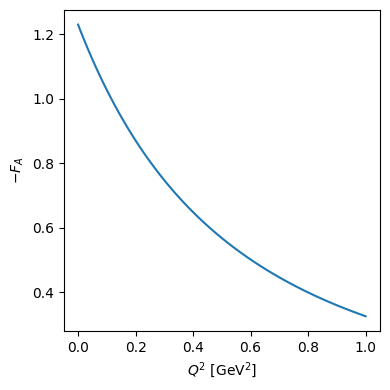

In [17]:
#use like

Q2 = 1.0 # in GeV2
nupid = 14 # muon neutrino
lsff = LSQEFFBlob(1.0, 14)

#also works with numpy vectorisation
Q2s = np.linspace(0, 1, 100)
lsff = LSQEFFBlob(Q2s, 14)

plt.plot(Q2s, -lsff.F_A)
plt.ylabel(r"$-F_A$")
plt.xlabel(r"$Q^2$ [GeV$^2$]")
plt.show()

### The Differential Cross Section: $d\sigma/dQ^2$

Now we have all the precalculations ready to implement the A, B, and C components of the differential cross section. This is just a lot of maths to encode, even for this relatively simple model. Implementing big blobs of maths is quite error prone, double check your (and my) working!

In [18]:
#A, B, and C are all implemented from p302 eqn 3.22

def A(lsff):
    t1 = (4 - lsff.q2_M2)*lsff.F_A2
    t2 = (4 + lsff.q2_M2)*lsff.F1_V2
    t3 = lsff.q2_M2 * lsff.etaF2_V2*(1 + 0.25*lsff.q2_M2)
    t4 = 4*lsff.q2_M2*lsff.F1_V*lsff.etaF2_V
    t5 = lsff.q2_M2 * (4 - lsff.q2_M2) * lsff.F3_A2
    t6 = lsff.m2_M2 * ( np.power(lsff.F1_V + lsff.etaF2_V,2) 
                  + np.power(lsff.F_A + 2*lsff.F_P,2) 
                  + (lsff.q2_M2 - 4)*(lsff.F3_V2 + lsff.F_P2) )

    return (0.25*(lsff.mlep2 - lsff.q2)/lsff.MNuc2)*(t1 - t2 - t3 - t4 + t5 - t6)
    
def B(lsff):
    t1 = -lsff.q2_M2 * lsff.F_A * (lsff.F1_V + lsff.etaF2_V)
    t2 = lsff.m2_M2 * ( (lsff.F1_V + 0.25*lsff.q2_M2*lsff.etaF2_V)*lsff.F3_V 
                    - (lsff.F_A + 0.5*lsff.F_P*lsff.q2_M2) * lsff.F3_A )
    return t1 - t2

def C(lsff):
    t1 = lsff.F_A2
    t2 = lsff.F1_V2
    t3 = lsff.q2_M2 * 0.25 * lsff.etaF2_V2
    t4 = lsff.q2_M2 * lsff.F3_A2
    return 0.25 * ( t1 + t2 - t3 - t4 )

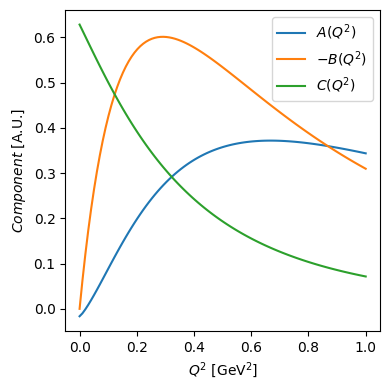

In [19]:
Q2s = np.linspace(0, 1, 100)
lsff = LSQEFFBlob(Q2s, 14)
plt.plot(Q2s, A(lsff), label=r"$A(Q^2)$")
plt.plot(Q2s, -B(lsff), label=r"$-B(Q^2)$")
plt.plot(Q2s, C(lsff), label=r"$C(Q^2)$")
plt.ylabel(r"$Component$ [A.U.]")
plt.xlabel(r"$Q^2$ [GeV$^2$]")
plt.legend()
plt.show()

Now we are ready to encode the full differential cross section calculation!

In [20]:
#p301 eqn 3.18
def LSQEDSigmaDQ2(E_nu_GeV, Q2_GeV2, nupid, M_V=M_V_GeV, M_A=M_A_GeV):
    enu = np.array(E_nu_GeV)
    
    lsff = LSQEFFBlob(Q2_GeV2, nupid, M_V=M_V, M_A=M_A)

    smu = np.zeros_like(enu + lsff.q2)
    dsdQ2 = np.zeros_like(enu + lsff.q2)

    enu_nonzero = enu > 0

    smu[enu_nonzero] = 4 * lsff.MNuc2 * enu[enu_nonzero] + lsff.q2[enu_nonzero] - lsff.mlep2
    
    dsdQ2[enu_nonzero] = (lsff.MNuc2 * GF * GF * np.power(cos_theta_C,2))/(8*pi*np.power(enu[enu_nonzero],2)) \
            * ( A(lsff)[enu_nonzero] 
                + -1 * lsff.nuornub * B(lsff)[enu_nonzero] * smu[enu_nonzero] / lsff.MNuc2 
                + C(lsff)[enu_nonzero] * np.power(smu[enu_nonzero],2) / np.power(lsff.MNuc2,2)
              )
    return dsdQ2

#### A Short Aside on Units
Around the literature you will often see neutrino cross sections reported in $10^{-38}$ cm$^2$. There are two reasons why I disagree with this convention and will choose this hill to die on.

1) Carrying around an exponent of $10^{-38}$ is needless and silly when we have scale prefixes.
2) If you want your result in cm$^2$ and multiply the $10^{-38}$ into your cross section value and then store your answer in a single precision floating point variable (`float`), then you're so close to IEEE 754 single precision float min (1.18 $10^{-38}$) that if you aren't very careful, computer maths will appear to stop working.

We're going to work in picobarns = $10^{-36}$ cm$^2$.

In [21]:
def LSQEDSigmaDQ2_pb(E_nu_GeV, Q2_GeV2, nupid, M_V=M_V_GeV, M_A=M_A_GeV):
    return LSQEDSigmaDQ2(E_nu_GeV, Q2_GeV2, nupid, M_V=M_V, M_A=M_A) / pb

/tmp/ipykernel_390424/2350562942.py:22: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


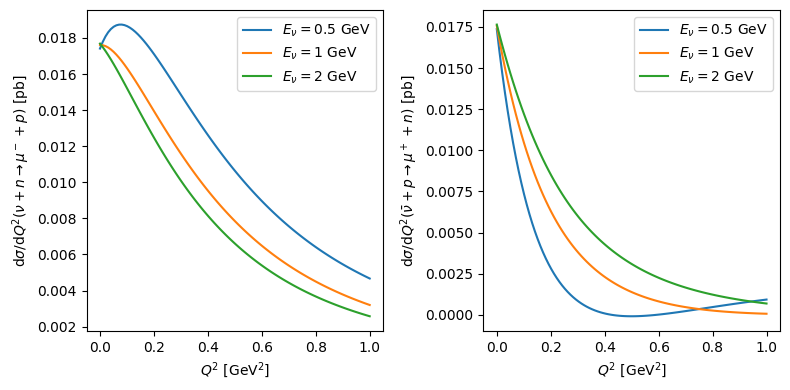

In [22]:
enu0_5 = 0.5 #GeV
enu1 = 1 #GeV
enu2 = 2 #GeV
Q2s = np.linspace(0, 1, 100)

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(8,4))

ax1.plot(Q2s, LSQEDSigmaDQ2_pb(enu0_5, Q2s, 14), label=r"$E_\nu = 0.5$ GeV")
ax1.plot(Q2s, LSQEDSigmaDQ2_pb(enu1, Q2s, 14), label=r"$E_\nu = 1$ GeV")
ax1.plot(Q2s, LSQEDSigmaDQ2_pb(enu2, Q2s, 14), label=r"$E_\nu = 2$ GeV")
ax1.set_ylabel(r"d$\sigma$/d$Q^{2} (\nu + n \rightarrow \mu^- + p)$ [pb]")
ax1.set_xlabel(r"$Q^{2}$ [GeV$^{2}$]")
ax1.legend()

ax2.plot(Q2s, LSQEDSigmaDQ2_pb(enu0_5, Q2s, -14), label=r"$E_\nu = 0.5$ GeV")
ax2.plot(Q2s, LSQEDSigmaDQ2_pb(enu1, Q2s, -14), label=r"$E_\nu = 1$ GeV")
ax2.plot(Q2s, LSQEDSigmaDQ2_pb(enu2, Q2s, -14), label=r"$E_\nu = 2$ GeV")
ax2.set_ylabel(r"d$\sigma$/d$Q^{2} (\bar{\nu} + p \rightarrow \mu^+ + n)$ [pb]")
ax2.set_xlabel(r"$Q^{2}$ [GeV$^{2}$]")
ax2.legend()

fig.show()

Great progress! we have implemented the Llewellyn Smith CCQE differential cross section... what next? And doesn't it look a bit weird that the cross section seems to *rise* with $Q^2$ for antineutrinos at $E_{\nu} = 0.5$ GeV above about $Q^2 \simeq 0.5$?

## Kinematics Calculation

So now we can calculate $d\sigma/dQ^2|_{E_\nu}(Q^2)$, but $Q^2$
is not observable. Lets see if we can calculate the observables.

Consider the interaction:

<div>
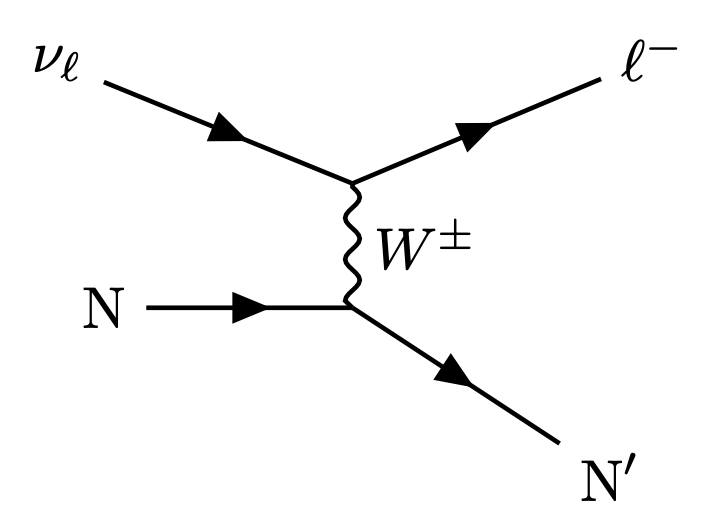
</div>

Choose coordinates such that: <br> 
$\vec{p}_\nu = \vec{p}_{\nu,z} = E_\nu$ <br>
$\vec{p}_N = 0$ <br>
$\vec{p}_{\ell,y} = \vec{p}_{{N^\prime},y} = 0$ <br>

In general, this choice may require a boost into the target nucleon rest frame 
and rotation, but should always be possible. The problem becomes 2D and we are 
left with 4 unknowns: $p_\ell$, $\cos{\theta_\ell}$, $p_{N^\prime}$, and 
$\cos{\theta_{N^\prime}}$. These can be uniquely determined by enforcing energy 
conservation, momentum conservation along two axes, and the $Q^2$ that we take
as input.

**Energy conservation**: $E_\nu + E_N = E_\ell + E_{N^\prime}$ <br/>
Initial nucleon $N$ at rest: $E_N = M_N$, $\vec{p}_N = 0$ <br>
[1] $E_\nu + M_N = E_\ell + E_{N^\prime}$ <br/>

**Linear momentum along $\hat{z}$**: <br>
[2] $E_\nu = p_\mu \cos{\theta_\ell} + p_{N^\prime} \cos{\theta_{N^\prime}}$ <br>

**Linear momentum along $\hat{x}$**: <br>
[3] $p_\mu \sin{\theta_\ell} = p_{N^\prime} \sin{\theta_{N^\prime}}$ <br>

From [2]$^2+$[3]$^2$: $(E_\nu - p_\ell\cos{\theta_\ell})^2 + p_\ell\sin{\theta_\ell}^2 = p_{N^\prime}^2(\cos{\theta_{N^\prime}}^2 + \sin{\theta_{N^\prime}}^2)$ <br>
$\rightarrow E_\nu^2 - 2E_\nu p_\ell\cos{\theta_\ell} + p_\ell^2(\cos{\theta_\ell}^2 + \sin{\theta_\ell}) = p_{N^\prime}^2$ <br>
[4] $\cos{\theta_\ell} = (E_\nu^2 + p_\ell^2 - p_{N^\prime}^2)/(2E_\nu p_\ell)$ <br><br>

$Q^2 = -q^2 = q_3^2 - q_0^2$
We know $\vec{p}_N = 0 \rightarrow \vec{p}_{N^\prime} = \vec{q}_3$ and so: <br>
[5] $Q^2 = p_{N^\prime}^2 - q_0^2$

From [1]: $E_{N^\prime} = E_\nu - E_\ell + M_N = q_0 + M_N$ <br/>
[6] $q_0 = E_{N^\prime} - M_N$ <br>
Squaring [6] and substituting $E_{N^\prime}^2 = p_{N^\prime}^2 + M_{N^\prime}^2$ <br>
[7] $q_0^2 + M_N^2 + 2M_Nq_0 = p_{N^\prime}^2 + M_{N^\prime}^2$ <br>
Including [5] and rearranging: <br>
[8] $q_0 = (Q^2 - (M_N^2 - M_{N^\prime}^2))/2M_N$

So now we can uniquely find $q_0$ from a chosen $Q^2$. Often at this stage, 
the $(M_N^2 - M_{N^\prime}^2)/2M_N$ term is neglected as neglible, but for
reasons that will become clearer later, we retain it. We can calculate the
final state lepton energy from the definition of $q_0 = E_\nu - E_\ell$,
which lets us calculate $p_\ell$. 

Using [5]: $p_{N^\prime} = \sqrt{Q^2 + q_0^2}$ <br>

We can then use [4] to find $\cos{\theta_\ell}$ and [2] to find 
$\cos{\theta_{N^\prime}}$, thus fully specifying the kinematics of the 
interaction.

In [23]:
class KinematicsBlob(object):
    def CalcKinematics(self, E_nu_GeV, Q2_GeV2, nupid, MNtgt):
        #use the default on-shell mass if unspecified
        if MNtgt == None:
            MNtgt = m_n if nupid > 0 else m_p
        MNpr = m_p if nupid > 0 else m_n
    
        if abs(nupid) == 12:
            mlep = m_e
        elif abs(nupid) == 14:
            mlep = m_mu
        else:
            raise RuntimeError("invalid nupid: %s passed to KinematicsBlob" % nupid)

        #enu and Q2 but with the shape of np.broadcast(enu, Q2)
        enu = E_nu_GeV + np.zeros_like(Q2_GeV2)
        Q2 = Q2_GeV2 + np.zeros_like(E_nu_GeV)

        # From [8] above
        q0 = (Q2 - (np.power(MNtgt,2) - np.power(MNpr,2)))/(2*MNtgt)

        # If elep is less than the rest mass, 
        # or if the four-momentum transfer is ,
        # less than the change in nucleon mass,
        # the reaction is energetically disallowed
        # build a numpy mask array to mask out 
        # invalid values from later calculations
        self.energetically_allowed = ~np.logical_or(q0 < 0, (enu - q0) < mlep)

        #we restrict the rest of the calculation to only the subset of
        #  allowed values.
        enuv = np.atleast_1d(enu)[self.energetically_allowed]
        Q2v = np.atleast_1d(Q2)[self.energetically_allowed]
        q0v = np.atleast_1d(q0)[self.energetically_allowed]

        elepv = enuv - q0v
        plepv = np.sqrt(np.power(elepv,2) - np.power(mlep,2))
        pnucv = np.sqrt(Q2v + np.power(q0v,2))

        # From [4] above
        lepctv = (np.power(enuv,2) + np.power(plepv,2) - np.power(pnucv,2))/(2*enuv*plepv)
        # From [2] above
        nucctv = (enuv - plepv * lepctv)/pnucv

        self.MN = MNtgt
        self.MNpr = MNpr
        self.mlep = mlep
        
        self.enu = E_nu_GeV
        self.Q2 = Q2_GeV2
        self.q0 = q0

        #as we used masked assignment below, these cannot be allowed to 
        #  decay to scalars
        self.plep = np.atleast_1d(np.zeros_like(enu))
        self.pnuc = np.atleast_1d(np.zeros_like(enu))
        self.lepct = np.atleast_1d(np.zeros_like(enu))
        self.nucct = np.atleast_1d(np.zeros_like(enu))

        self.plep[self.energetically_allowed] = plepv
        self.pnuc[self.energetically_allowed] = pnucv
        self.lepct[self.energetically_allowed] = lepctv
        self.nucct[self.energetically_allowed] = nucctv
        
    def __init__(self, E_nu_GeV, Q2_GeV2, nupid, MNtgt=None):
        self.CalcKinematics(E_nu_GeV, Q2_GeV2, nupid, MNtgt)

    def __str__(self):
        if isinstance(self.plep, np.ndarray):
            return f"[\n  enu = {self.enu},\n  Q2 = {self.Q2},\n  q0 = {self.q0},\n  plep = {self.plep},\n  lepct = {self.lepct}\n]"
        return f"[ Q2 = {self.Q2}, q0 = {self.q0:.2}, plep = {self.plep:.2}, lepct = {self.lepct:.2} ]"

# works with numbers
print(KinematicsBlob(1, 1, 12))
# numpy inputs for Q2
print(KinematicsBlob(1,np.linspace(0.1,0.5,5), 12))
# numpy inputs for Enu
print(KinematicsBlob(np.linspace(0.8,1.2,5), 1, 12))
# numpy inputs for both!
print(KinematicsBlob(np.linspace(0.8,1.2,5), np.linspace(0.1,0.5,5), 12))

[
  enu = 1,
  Q2 = 1,
  q0 = 0.5308690493787018,
  plep = [0],
  lepct = [0]
]
[
  enu = 1,
  Q2 = [0.1 0.2 0.3 0.4 0.5],
  q0 = [0.05192401 0.10514012 0.15835624 0.21157235 0.26478847],
  plep = [0.94807586 0.89485973 0.84164361 0.78842748 0.73521135],
  lepct = [0.94726161 0.88825066 0.82177732 0.74633055 0.65996179]
]
[
  enu = [0.8 0.9 1.  1.1 1.2],
  Q2 = 1,
  q0 = [0.53086905 0.53086905 0.53086905 0.53086905 0.53086905],
  plep = [0.26913047 0.3691306  0.46913067 0.56913072 0.66913076],
  lepct = [-1.32229256 -0.50503738 -0.06580081  0.20133402  0.37730171]
]
[
  enu = [0.8 0.9 1.  1.1 1.2],
  Q2 = [0.1 0.2 0.3 0.4 0.5],
  q0 = [0.05192401 0.10514012 0.15835624 0.21157235 0.26478847],
  plep = [0.74807582 0.79485971 0.84164361 0.8884275  0.93521139],
  lepct = [0.91645233 0.86021295 0.82177732 0.79534835 0.777234  ]
]


#### Plotting the Kinematics

lets see how the observable kinematics vary as a function of $Q^2$:

Q: Can you find any weird behavior when plotting different Q2 ranges for enu?


/tmp/ipykernel_390424/1649915820.py:19: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


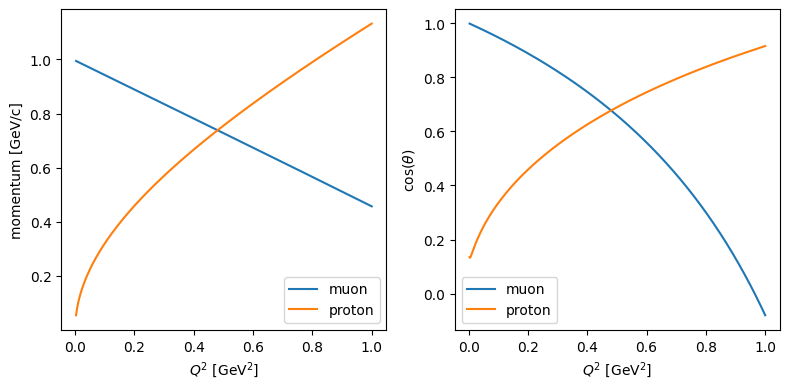

In [24]:
def plotkins(enu, Q2max):
    
    kb = KinematicsBlob(enu, np.linspace(0,Q2max,1000), 14)
    
    fig, (ax1,ax2) = plt.subplots(1,2, figsize=(8,4))
    
    ax1.plot(kb.Q2[kb.energetically_allowed], kb.plep[kb.energetically_allowed],label="muon")
    ax1.plot(kb.Q2[kb.energetically_allowed], kb.pnuc[kb.energetically_allowed],label="proton")
    ax1.set_ylabel("momentum [GeV/c]")
    ax1.set_xlabel(r"$Q^2$ [GeV$^2$]")
    ax1.legend()
    
    ax2.plot(kb.Q2[kb.energetically_allowed], kb.lepct[kb.energetically_allowed],label="muon")
    ax2.plot(kb.Q2[kb.energetically_allowed], kb.nucct[kb.energetically_allowed],label="proton")
    ax2.set_ylabel(r"$\cos(\theta)$")
    ax2.set_xlabel(r"$Q^2$ [GeV$^2$]")
    ax2.legend()
    
    fig.show()

enu = 1
Q2 = 1
plotkins(enu, Q2)

Can $Q^2$ be larger than $E_\nu$?

/tmp/ipykernel_390424/1649915820.py:19: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


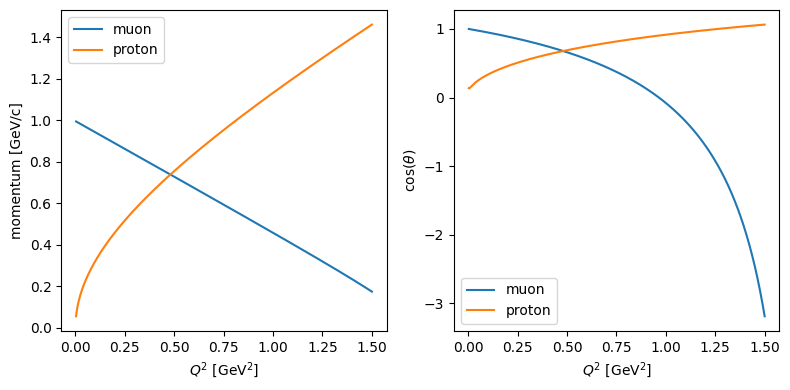

In [25]:
enu = 1
Q2 = 1.5
plotkins(enu,Q2)

At some $Q^2 > Q^2_\text{max}$, momentum cannot be conserved as [4] would imply
$\cos{\theta_\ell} < -1$. We can extend our previous `KinematicsBlob` to report
failure if the kinematics are unphysical for a given $E_\nu$ and $Q^{2}$.

In [26]:
class PhysicalKinematicsBlob(KinematicsBlob):
    def __init__(self, E_nu_GeV, Q2_GeV2, nupid, MNtgt=None):
        super().__init__(E_nu_GeV, Q2_GeV2, nupid, MNtgt) # call the KinematicsBlob constructor
        self.physical = np.logical_and(self.energetically_allowed,(np.abs(self.lepct) <= 1))

enu = 1
Q2 = 1
pkb = PhysicalKinematicsBlob(enu,Q2,14)
print("Is Enu = 1, Q2 = 1 for numus kinematically allowed?", pkb.physical)

enu = 1
Q2 = 1.28
pkb = PhysicalKinematicsBlob(enu,Q2,14)
print("Is Enu = 1, Q2 = 1.28 for numus kinematically allowed?", pkb.physical)

enu = 1
Q2 = 1.28
pkb = PhysicalKinematicsBlob(enu,Q2,12)
print("Is Enu = 1, Q2 = 1.28 for nues kinematically allowed?", pkb.physical)

enu = 1
Q2 = 2
pkb = PhysicalKinematicsBlob(enu,Q2,12)
print("Is Enu = 1, Q2 = 2 for nues kinematically allowed?", pkb.physical)

#also works with numpy vectorisation along the enu, Q2 axes separately, or simultaneously
pkb = PhysicalKinematicsBlob(1,np.linspace(0,2,20),12)
print(pkb.physical)
pkb = PhysicalKinematicsBlob(np.linspace(0,2,20),1,12)
print(pkb.physical)

Is Enu = 1, Q2 = 1 for numus kinematically allowed? [ True]
Is Enu = 1, Q2 = 1.28 for numus kinematically allowed? [False]
Is Enu = 1, Q2 = 1.28 for nues kinematically allowed? [ True]
Is Enu = 1, Q2 = 2 for nues kinematically allowed? [False]
[False  True  True  True  True  True  True  True  True  True  True  True
  True False False False False False False False]
[False False False False False False False False  True  True  True  True
  True  True  True  True  True  True  True  True]


/tmp/ipykernel_390424/3611822250.py:23: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


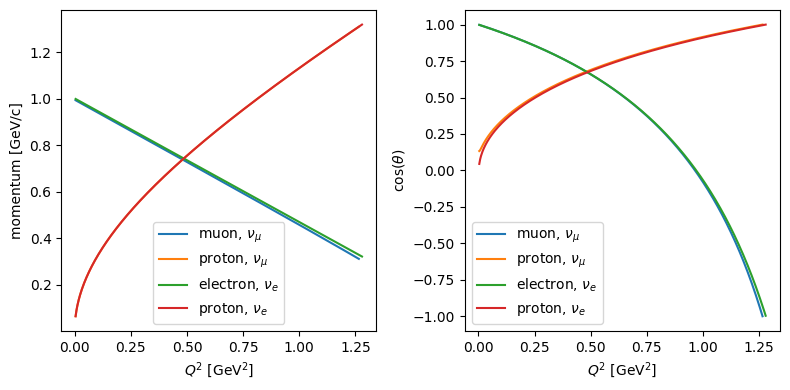

In [27]:
def plotphyskins(enu, Q2max):
    kbnumu = PhysicalKinematicsBlob(enu, np.linspace(0,Q2max,1000), 14)
    kbnue = PhysicalKinematicsBlob(enu, np.linspace(0,Q2max,1000), 12)

    fig, (ax1,ax2) = plt.subplots(1,2, figsize=(8,4))
    
    ax1.plot(kbnumu.Q2[kbnumu.physical],kbnumu.plep[kbnumu.physical],label=r"muon, $\nu_\mu$")
    ax1.plot(kbnumu.Q2[kbnumu.physical],kbnumu.pnuc[kbnumu.physical],label=r"proton, $\nu_\mu$")
    ax1.plot(kbnue.Q2[kbnue.physical],kbnue.plep[kbnue.physical],label=r"electron, $\nu_e$")
    ax1.plot(kbnue.Q2[kbnue.physical],kbnue.pnuc[kbnue.physical],label=r"proton, $\nu_e$")
    ax1.set_ylabel("momentum [GeV/c]")
    ax1.set_xlabel(r"$Q^2$ [GeV$^2$]")
    ax1.legend()
    
    ax2.plot(kbnumu.Q2[kbnumu.physical],kbnumu.lepct[kbnumu.physical],label=r"muon, $\nu_\mu$")
    ax2.plot(kbnumu.Q2[kbnumu.physical],kbnumu.nucct[kbnumu.physical],label=r"proton, $\nu_\mu$")
    ax2.plot(kbnue.Q2[kbnue.physical],kbnue.lepct[kbnue.physical],label=r"electron, $\nu_e$")
    ax2.plot(kbnue.Q2[kbnue.physical],kbnue.nucct[kbnue.physical],label=r"proton, $\nu_e$")
    ax2.set_ylabel(r"$\cos(\theta)$")
    ax2.set_xlabel(r"$Q^2$ [GeV$^2$]")
    ax2.legend()
    
    fig.show()

enu = 1
Q2 = 2
plotphyskins(enu,Q2)

We will define a new version of the cross section which is only non-zero for kinematically allowed regions

In [28]:
def LSQEDSigmaDQ2Physical_pb(E_nu_GeV, Q2_GeV2, nupid, M_V=M_V_GeV, M_A=M_A_GeV):

    #enu and Q2 but with the shape of np.broadcast(enu, Q2)
    enu = np.atleast_1d(E_nu_GeV + np.zeros_like(Q2_GeV2))
    Q2 = np.atleast_1d(Q2_GeV2 + np.zeros_like(E_nu_GeV))

    #as we used masked assignment, this must not be allowed to decay to a scalar
    dsdQ2 = np.atleast_1d(np.zeros_like(enu))
    
    pkb = PhysicalKinematicsBlob(enu, Q2, nupid)

    dsdQ2[pkb.physical] = LSQEDSigmaDQ2(enu[pkb.physical], Q2[pkb.physical], nupid) / pb
    
    return dsdQ2

/tmp/ipykernel_390424/3334778542.py:22: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


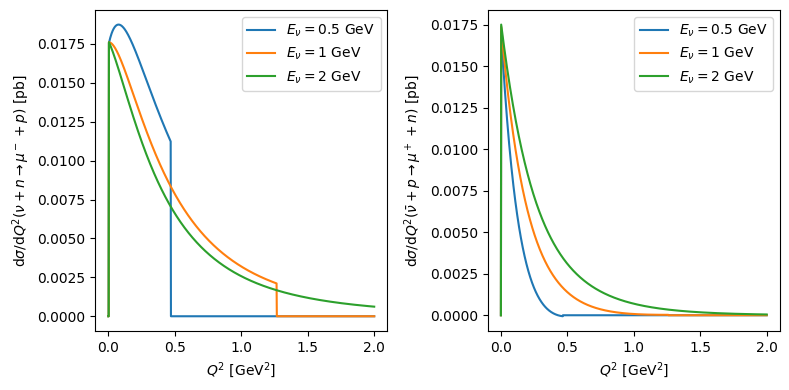

In [29]:
enu0_5 = 0.5 #GeV
enu1 = 1 #GeV
enu2 = 2 #GeV
Q2s = np.linspace(0, 2, 1000)

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(8,4))

ax1.plot(Q2s, LSQEDSigmaDQ2Physical_pb(enu0_5, Q2s, 14), label=r"$E_\nu = 0.5$ GeV")
ax1.plot(Q2s, LSQEDSigmaDQ2Physical_pb(enu1, Q2s, 14), label=r"$E_\nu = 1$ GeV")
ax1.plot(Q2s, LSQEDSigmaDQ2Physical_pb(enu2, Q2s, 14), label=r"$E_\nu = 2$ GeV")
ax1.set_ylabel(r"d$\sigma$/d$Q^{2} (\nu + n \rightarrow \mu^- + p)$ [pb]")
ax1.set_xlabel(r"$Q^{2}$ [GeV$^{2}$]")
ax1.legend()

ax2.plot(Q2s, LSQEDSigmaDQ2Physical_pb(enu0_5, Q2s, -14), label=r"$E_\nu = 0.5$ GeV")
ax2.plot(Q2s, LSQEDSigmaDQ2Physical_pb(enu1, Q2s, -14), label=r"$E_\nu = 1$ GeV")
ax2.plot(Q2s, LSQEDSigmaDQ2Physical_pb(enu2, Q2s, -14), label=r"$E_\nu = 2$ GeV")
ax2.set_ylabel(r"d$\sigma$/d$Q^{2} (\bar{\nu} + p \rightarrow \mu^+ + n)$ [pb]")
ax2.set_xlabel(r"$Q^{2}$ [GeV$^{2}$]")
ax2.legend()

fig.show()

## The Cross Section for the Hard Scatter

To calculate the cross section, $\sigma(E_{\nu})$, we need to integrate the differential cross-section over the kinematically allowed space. For this simple interaction, we can actually analytically solve the allowed $Q^2$ range for a given $E_\nu$. The detailed algebra-crunching can be found [in the supplementary material](#Kinematic-Limits-in-$Q^2$). Below we define a function that returns the upper and lower bounds for a given $E_\nu$, neutrino species, and target nucleon mass.

In [30]:
def AllowedQ2Range(E_nu_GeV, nupid, MNtgt=None):

    #This allows us to specify an off-shell mass
    #  for the target nucleon for kinematics calculation
    if MNtgt == None:
        MNtgt = m_n if nupid > 0 else m_p

    MNpr = m_p if nupid > 0 else m_n

    if abs(nupid) == 12:
        mlep = m_e
    elif abs(nupid) == 14:
        mlep = m_mu
    else:
        raise RuntimeError("invalid nupid: %s passed to KinematicsBlob" % nupid)

    enu = np.array(E_nu_GeV)

    ## Apply energetic constraint in here check that low limit is more than minQ2 for energetically viable
    
    DM2 = (np.power(MNtgt,2) - np.power(MNpr,2))

    enu_MN = enu/MNtgt
    mlep2 = np.power(mlep,2)
    
    a = 1 + 2 * enu_MN
    mb = 2 * (2 * np.power(enu,2) - (1 + enu_MN)*mlep2 + enu_MN * DM2)
    c = np.power(mlep,4) - 2 * mlep2 * DM2 * enu_MN

    # if the discriminant is <= 0 then there is no allowed Q2 phase space for this E_nu
    disc = np.power(mb,2) - 4 * a * c
    vmask = disc > 0

    low_lim = np.zeros_like(disc)
    up_lim = np.zeros_like(disc)


    ##### !!!! Move this to a separate function
    # This is not failsafe, but we shunt the limits in by machine precision to try and stop
    #  the upper limit resulting in unphysical events when lepct > -1 check is applied
    up_lim[vmask] = np.nextafter((mb[vmask] + np.sqrt(disc[vmask]))/(2*a[vmask]), 0)
    low_lim[vmask] = np.nextafter((mb[vmask] - np.sqrt(disc[vmask]))/(2*a[vmask]), up_lim[vmask])

    return (low_lim,up_lim)

/tmp/ipykernel_390424/2640065581.py:21: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


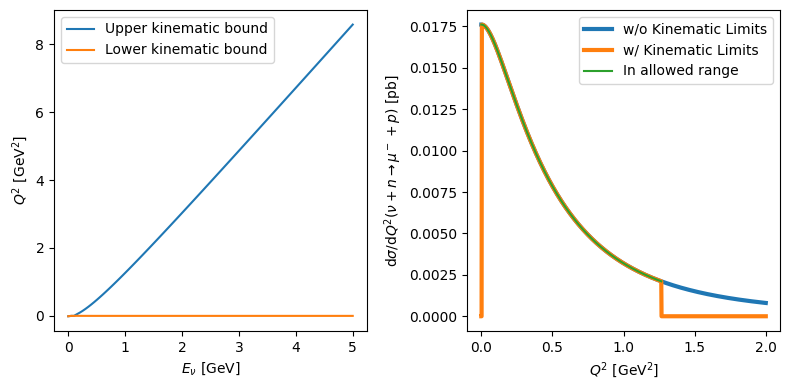

In [31]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(8,4))

enus = np.linspace(0,5,100)
ax1.plot(enus,AllowedQ2Range(enus, 14)[1], label="Upper kinematic bound")
ax1.plot(enus,AllowedQ2Range(enus, 14)[0], label="Lower kinematic bound")
ax1.set_ylabel(r"$Q^2$ [GeV$^2$]")
ax1.set_xlabel(r"$E_\nu$ [GeV]")
ax1.legend()

enu = 1
Q2s = np.linspace(0, 2, 1000)
Q2s_allowed = np.linspace(*AllowedQ2Range(enu, 14), 1000)

ax2.plot(Q2s, LSQEDSigmaDQ2_pb(enu, Q2s, 14), label=r"w/o Kinematic Limits", lw=3)
ax2.plot(Q2s, LSQEDSigmaDQ2Physical_pb(enu, Q2s, 14), label=r"w/ Kinematic Limits", lw=3)
ax2.plot(Q2s_allowed, LSQEDSigmaDQ2_pb(enu, Q2s_allowed, 14), label=r"In allowed range")
ax2.set_ylabel(r"d$\sigma$/d$Q^{2} (\nu + n \rightarrow \mu^- + p)$ [pb]")
ax2.set_xlabel(r"$Q^{2}$ [GeV$^{2}$]")
ax2.legend()

fig.show()

Q: Find the kinematic threshold for the reaction

In [32]:
enu = 1
Q2s_allowed = np.linspace(*AllowedQ2Range(enu, 14), 10)
kb = PhysicalKinematicsBlob(enu, Q2s_allowed, 14)
print("energetically_allowed:", kb.energetically_allowed)
print("physical:", kb.physical)
print("q0:", kb.q0)
print("lepct:", kb.lepct)


energetically_allowed: [False  True  True  True  True  True  True  True  True  True]
physical: [False  True  True  True  True  True  True  True  True  True]
q0: [-0.00128311  0.07353846  0.14836004  0.22318162  0.2980032   0.37282478
  0.44764636  0.52246793  0.59728951  0.67211109]
lepct: [ 0.          0.92411547  0.83479271  0.72807871  0.5982819   0.43688348
  0.23049719 -0.04328215 -0.4253126  -1.        ]


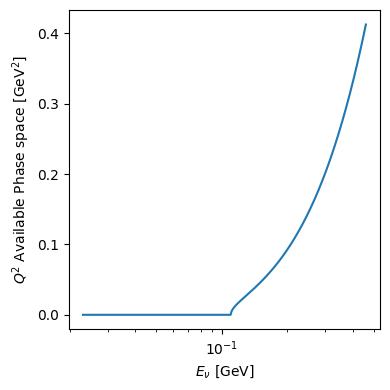

In [33]:
low, up = AllowedQ2Range(np.log(np.logspace(1E-2,0.2,1000)), 14)
plt.plot(np.log(np.logspace(1E-2,0.2,1000)), up - low)
plt.xscale('log')
plt.xlabel(r"$E_\nu$ [GeV]")
plt.ylabel(r"$Q^2$ Available Phase space [GeV$^2$]")
plt.show()

We can then use scipy to do the integral over $Q^2$:

In [34]:
from scipy import integrate as spi

def LSQESigma(E_nu_GeV, nupid):
    Q2r = AllowedQ2Range(E_nu_GeV, nupid)
    return spi.quad(lambda Q2: LSQEDSigmaDQ2_pb(E_nu_GeV, Q2, nupid), *Q2r)[0]

def LSQESigmaPhysical(E_nu_GeV, nupid):
    Q2r = AllowedQ2Range(E_nu_GeV, nupid)
    return spi.quad(lambda Q2: LSQEDSigmaDQ2Physical_pb(E_nu_GeV, Q2, nupid), *Q2r)[0]


print("total cross section at 1 GeV:", LSQESigmaPhysical(1.0, 14))

total cross section at 1 GeV: 0.009632848182505357


Now lets make a plot of the cross section, we're hoping to see something like the below from the LS paper:
<div>
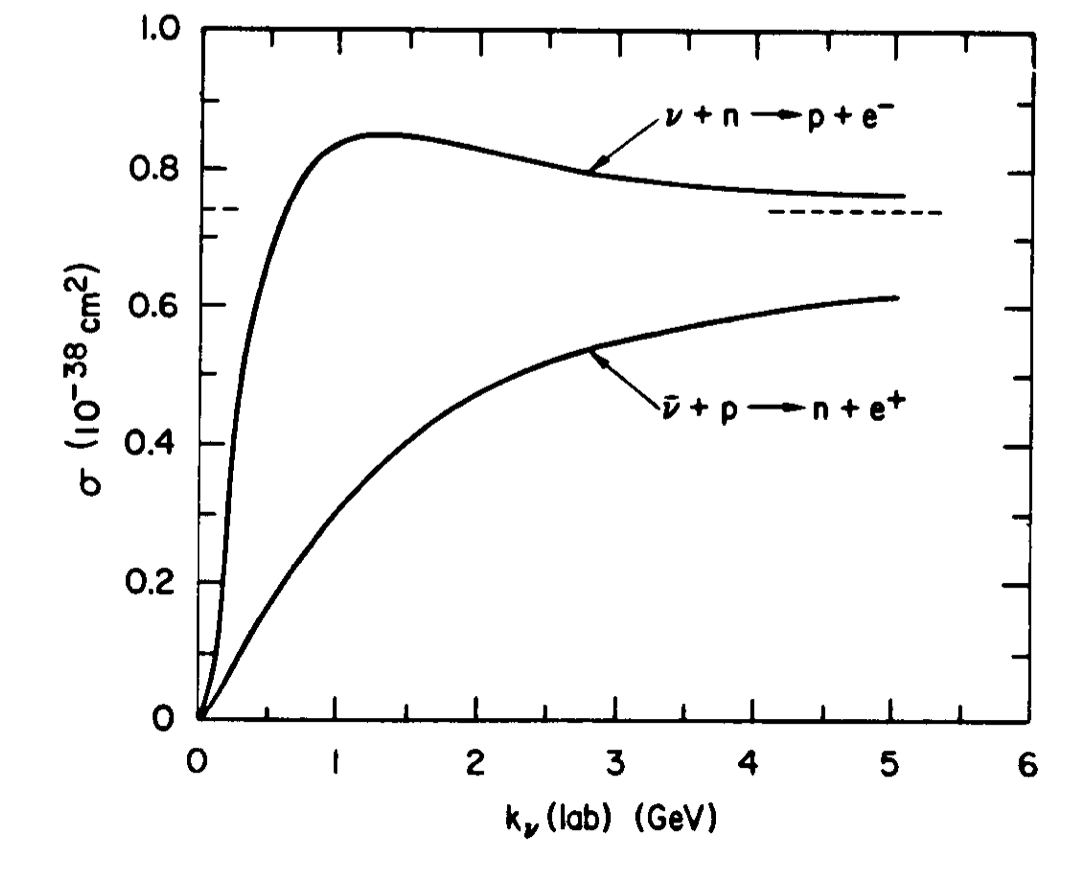
</div>

In [35]:
enus = np.linspace(0,6,100)
sig_numu = [LSQESigma(enu,12) for enu in enus]
sig_numubar = [LSQESigma(enu,-12) for enu in enus]

plt.plot(enus,sig_numu,label=r"$\nu_\text{e} + \text{n} \rightarrow \text{e}^- + \text{p}$")
plt.plot(enus,sig_numubar,label=r"$\bar{\nu}_\text{e} + \text{p} \rightarrow \text{e}^+ + \text{n}$")
plt.ylabel(r"$\sigma(E_\nu)$ [pb]")
plt.xlabel(r"$E_\nu$ [GeV]")
plt.legend()
plt.show()

ValueError: 
\nu_\text{e} + \text{n} \rightarrow \text{e}^- + \text{p}
    ^
ParseSyntaxException: Expected {accent | symbol | function | operatorname | group | frac | dfrac | binom | genfrac | overset | underset | sqrt | overline}, found '\'  (at char 4), (line:1, col:5)

<Figure size 400x400 with 1 Axes>

### Success!

We have reproduced a plot from a 50 year old paper for two-body quasi-elastic scattering. Break out the champagne 🥂

**Points at LSQEDSigmaDQ2Physical** *Is this an event generator?*

**Slaps top of LSQESigma** *This function can calculate so many cross sections!*

Now we have implemented a model, its time to build the actual event generator.

<hr>

### Questions

* Why does the cross section flatten off for $\nu$? Does it flatten off for $\bar{\nu}$?
* Why is there a bump at low energy for $\nu$ and not for $\bar{\nu}$?
* What are the implications of the very different values of $\sigma_\nu$ and $\sigma_\bar{\nu}$ for CPV searches at few-GeV neutrino oscillation experiments?

<hr>

## Aside: Monte Carlo Sampling

The problem of building a Monte Carlo Event Generator (MCEG) is the problem of choosing all relevant properties of an event such that they statistically obey the input model(s). A single CCQE event chosen from out model may have any kinematically allowed $Q^2$, but if we choose 1E6 separate events, we should be able to reproduce all of the predicted distributions of the model.

We will start with a simpler version of the problem though. How can we pick random numbers in the range $x \in [0,\pi]$ such that they are distributed according to $\sin{x}$?

### Rejection Sampling

First, lets draw $\sin{x}$ over the interval

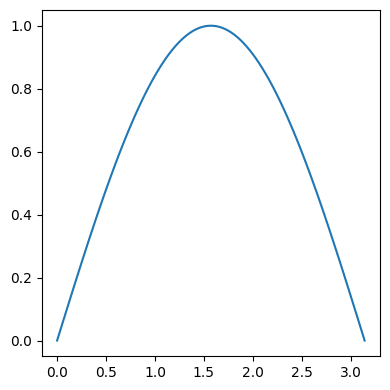

In [36]:
x = np.linspace(0,pi,100)
plt.plot(x,np.sin(x))
plt.show()

The basic idea of rejection sampling, is to throw pairs of random numbers over the domain and range of the function of interest and 'reject' those that lie above the function. In this way you choose values along the domain, proportionally to the value of the function. We will use scipy for random numbers.

/tmp/ipykernel_390424/3719278534.py:36: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Acceptance efficiency: 6324/10000 = 63.24%


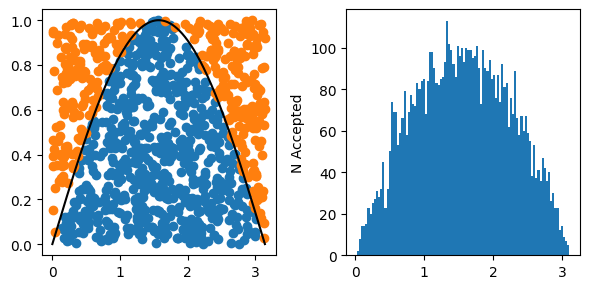

In [37]:
def plot_rejsample(f, fdomain, frange, ntries=1000):

    xs = uniform.rvs(fdomain[0],fdomain[1] - fdomain[0], size=ntries)
    ys = uniform.rvs(frange[0],frange[1] - frange[0], size=ntries)
    
    accepted = ([],[])
    rejected = ([],[])
    ntoscatter = 0
    
    all_accepted = []
    
    for x,y in zip(xs,ys):
        if y < f(x):
            if(ntoscatter < 1000):
                accepted[0].append(x)
                accepted[1].append(y)
                ntoscatter += 1
            
            all_accepted.append(x)
        elif(ntoscatter < 1000):
            rejected[0].append(x)
            rejected[1].append(y)
            ntoscatter += 1

    fig, (ax1,ax2) = plt.subplots(1,2, figsize=(6,3))
    
    ax1.scatter(accepted[0], accepted[1])
    ax1.scatter(rejected[0], rejected[1])
    
    xpoints = np.linspace(fdomain[0], fdomain[1], 1000)
    ax1.plot(xpoints, [f(x) for x in xpoints], c="black")
    
    ax2.hist(all_accepted)
    ax2.set_ylabel("N Accepted")
    
    fig.show()
    
    print("Acceptance efficiency: %s/%s = %s%%" % (len(all_accepted),ntries, 100 * len(all_accepted)/ntries) )

plot_rejsample(np.sin,(0,pi),(0,1), 10000)

Not the smoothest histogram ever, but if you turn up the number of samples, it gets better and better.

#### Determining the Function Range

Finding the range of a general function is a class of problems with many possible approaches. A simple first approach that will work for many low dimensional problems is a simple grid search. We can also use `scipy` to do the maximum value finding for us. Lets use a slightly more fiddly function to illustrate an important consideration when using rejection sampling.

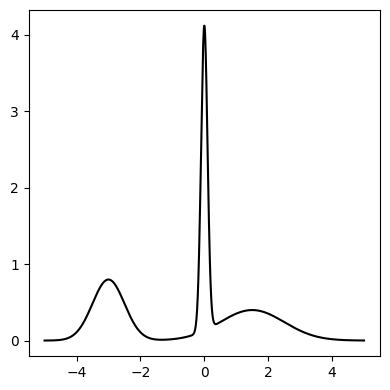

In [38]:
def gaussian(x, mu, sigma):
    return (1/(sigma*np.sqrt(2*pi)))*np.exp(-0.5*np.power(x - mu,2)/np.power(sigma,2))

def myfunc(x):
    return gaussian(x,-3,0.5) + gaussian(x,0,0.1) + gaussian(x, 1.5,1)

xpoints = np.linspace(-5,5,1000)
plt.plot(xpoints, myfunc(xpoints), c="black")
plt.show()

Lets ask `scipy` to find the maximum (or actually the minimum of `-myfunc(x)`), there are various global minimizers in `scipy`, we will use the `optimize.shgo` function here which seemed to work well with minimal inputs.

In [39]:
import scipy.optimize as opt

result = opt.differential_evolution(lambda x: -myfunc(x), [(-5,5),])
max_func_val = -result.fun
print("Expected max at %.3f, found mx at %.3f" % (myfunc(0),max_func_val))

Expected max at 4.119, found mx at 0.798


So `scipy` managed to find it pretty well! 

/tmp/ipykernel_390424/3719278534.py:36: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Acceptance efficiency: 2844/10000 = 28.44%


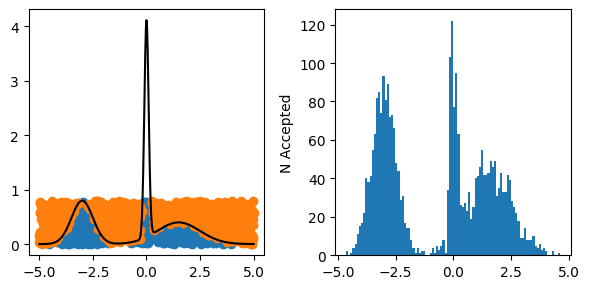

In [40]:
plot_rejsample(myfunc,(-5,5),(0,max_func_val), 10000)

You should notice here that while the accepted samples have the correct statistical properties, a much smaller fraction of the throws are accepted, about $\lesssim$10% vs. $\sim$60% for the $\sin{x}$ problem. The reason for this should be obvious from the plots. The acceptance probability goes like the ratio of the integral of the function over the domain to the domain times the range. For sharply peaking functions that have a large domain, the efficiency of this method is poor. There are a number of methods that are better suited to functions like this, or functions with highly multivariate domains. We will discuss one simple extension later, but more sophisticated approaches are outside the scope of this course.

Expanding the interval of the random variables beyond the true range of the function does not change the statistical distribution of the accepted samples, as each value along the domain is still chosen proportionally to the function value at that point. However, it does lower the efficiency, as can be seen in the example below.

/tmp/ipykernel_390424/3719278534.py:36: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Acceptance efficiency: 6428/100000 = 6.428%


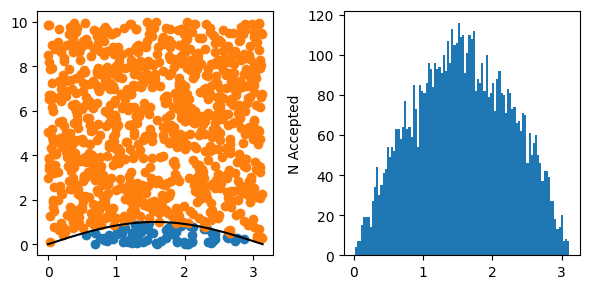

In [41]:
plot_rejsample(np.sin,(0,pi),(0,10), 100000)

Where now the efficiency is more like that of `myfunc`. What about if we make the interval too small for the function range?

/tmp/ipykernel_390424/3719278534.py:36: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Acceptance efficiency: 74850/100000 = 74.85%


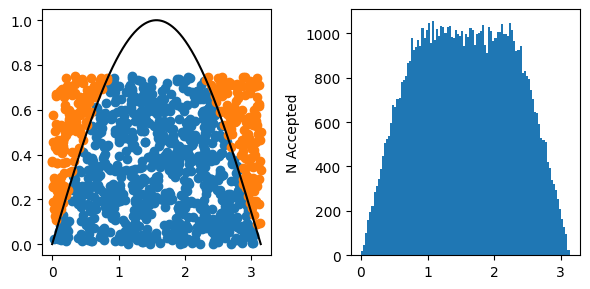

In [42]:
plot_rejsample(np.sin,(0,pi),(0,0.75), 100000)

Here we can see that, if the maximum value is incorrectly judged to be below the true maximum value of the function, the statistical properties of the accepted sample will no longer be correctly distributed according to the input function. As a result, it is important for the validity of your sampler that the ceiling is carefully chosen to ensure that it is larger than the maximum function value. 

As the dimensionality of the domain gets larger, and functions more *peaky* grid searching can be slow, inefficient, or inaccurate at finding the true range of the function, it is quite common to add a bit of 'headroom' to the determined maximum (and minimum, if the function has negative values).

We are now equipped with all the tools to build our very first MCEG. It wont be the most efficienct generator ever written, but it should be a valid implementation of the cross section model that we aimed to use.

## The Free Nucleon Kinematics Picker

Let's try choosing $Q^2$ according to our differential cross section calculation. To do this correctly, we will need to guess the range of $d\sigma/dQ^2$.

Function  maximum at:  0.018743469924519675


/tmp/ipykernel_390424/3719278534.py:36: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Acceptance efficiency: 42315/50000 = 84.63%


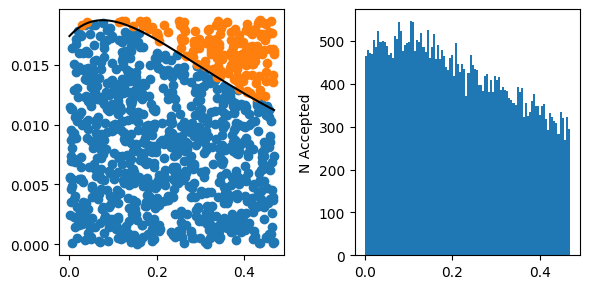

In [43]:
enu = 0.5
nupid = 14

q2r = AllowedQ2Range(enu, nupid)

result = opt.differential_evolution(lambda Q2: -LSQEDSigmaDQ2_pb(enu, Q2, nupid), [q2r,])
max_func_val = -result.fun
print("Function  maximum at: ", max_func_val)

plot_rejsample(lambda Q2: LSQEDSigmaDQ2_pb(enu, Q2, nupid), q2r, (0, max_func_val), 50000)

**Is this an event generator?** Sort of... its more of an interaction kinematics picker. To make a real event generator we need to resolve all the observable kinematics, which we know how to do, predict the interaction rate for a given flux of input neutrinos, and package the result in some form that we can analyse.

We're going to define a new rejection sampling function that takes the number of samples to generate, rather than the number of tries to attempt. This means that if we ask for 1000 samples, we get 1000 samples. Functions that are more inefficient to sample simply take more CPU cycles to produce our events. We will also keep track of the integral of the function calculated all tries, which will allow us to calculate the total cross section.

In [52]:
def rejsample1D(f, fdomain, frange, nsamples, blocksize=1000):

    samples = np.array([])
    fvals = np.array([])
    fvals2 = np.array([])
    ntries = 0

    while len(samples) < nsamples:
        #to make the best use of numpy vectorisation we will
        #  work in blocks until we have at least enough samples
        x = uniform.rvs(fdomain[0],fdomain[1] - fdomain[0], size=blocksize)
        fx = f(x)
        y = uniform.rvs(frange[0], frange[1] - frange[0], size=blocksize)

        accepted = y < fx
    
        samples = np.append(samples, x[accepted])
        fvals = np.append(fvals, fx)
        fvals2 = np.append(fvals2, fx**2)

        ntries += blocksize

    return samples[0:nsamples], fvals.mean() * (fdomain[1] - fdomain[0]), np.sqrt((fvals2.mean() - fvals.mean()**2)/(ntries-1)) * (fdomain[1] - fdomain[0]), ntries

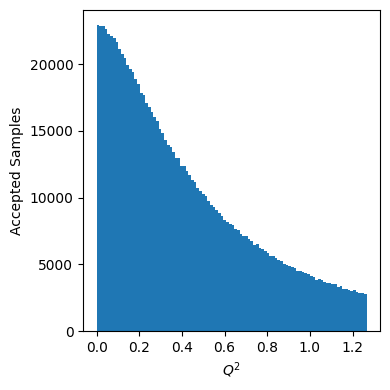

Total cross section for 1 GeV muon neutrinos from MC integration: 0.00968 +/- 4.00730e-06 pb
Total cross section for 1 GeV muon neutrinos from spi.quad integration: 0.00968 pb


In [53]:
enu = 1
nupid = 14

q2r = AllowedQ2Range(enu, nupid)

result = opt.differential_evolution(lambda Q2: -LSQEDSigmaDQ2_pb(enu, Q2, nupid), [q2r,])
max_func_val = -result.fun

Q2Samples, sigint, error, ntries = rejsample1D(lambda Q2: LSQEDSigmaDQ2_pb(enu, Q2, nupid), q2r, (0, max_func_val), 1000000)
plt.hist(Q2Samples)
plt.ylabel("Accepted Samples")
plt.xlabel(r"$Q^2$")
plt.show()

print("Total cross section for 1 GeV muon neutrinos from MC integration: %.5f +/- %.5e pb" % (sigint, error))
print("Total cross section for 1 GeV muon neutrinos from spi.quad integration: %.5f pb" % LSQESigma(enu,nupid))

For each chosen $Q^2$, we then can calculate the observable kinematics. Lets make our first histogram of observable kinematics from our budding event generator!

+++ Add MC error

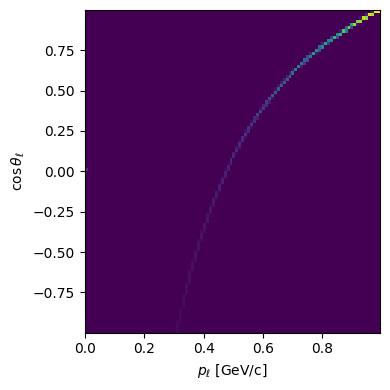

In [46]:
events = PhysicalKinematicsBlob(enu,Q2Samples,nupid)

plt.hist2d(events.plep, events.lepct, bins=[100,100])
plt.ylabel(r"$\cos{\theta_\ell}$")
plt.xlabel(r"$p_\ell$ [GeV/c]")
plt.show()

This looks as expected from our kinematic constraint plots that we made earlier, but now we can see the effect of the cross section shape as a function of $Q^2$ where events are more likely to be 'forward' (small $\theta_\ell$).

### A Spread of Energies

One glaring issue with our event generator so far is that we have only used it for single neutrino energies at a time. Real neutrino beams have significant width, so before we can use our generator to make predictions for some actual data we need to decide how to incorporate multiple energies.

There are various ways to approach this step. Both attempt to solve the integral: 
$N = \iint\Phi(E_\nu)\frac{\text{d}\sigma}{\text{d}\mathbf{x}}(E_\nu,\mathbf{x}) dE_\nu d\mathbf{x}$,
where $\Phi(E_\nu)$ is the neutrino flux and $\mathbf{x}$ are the kinematic variables that the model(s) are encoded in, in our case, $Q^2$.

We are going to discuss two approaches:

1) Sample the multivariate integrand directly by choosing samples according to $\Phi(E_\nu)\frac{\text{d}\sigma}{\text{d}\mathbf{x}}(E_\nu,\mathbf{x})$.
2) Factorise the problem by pre-calculating $\sigma(E_\nu) = \int \frac{\text{d}\sigma}{\text{d}\mathbf{x}}(E_\nu,\mathbf{x}) d\mathbf{x}$ over a grid of $E_\nu$ so that you can pick $E_\nu$ from $\Phi(E_\nu)\sigma(E_\nu)$ and then pick $\mathbf{x}$ from $\frac{\text{d}\sigma}{\text{d}\mathbf{x}}(E_\nu,\mathbf{x})|_{E_\nu}$.

### Multivariate Sampling

For the first approach, we can extend our rejsample1D function to sample both $E_\nu$ and $Q^2$ simultaneously.

We will start with a simple toy gaussian neutrino energy spectrum as below:

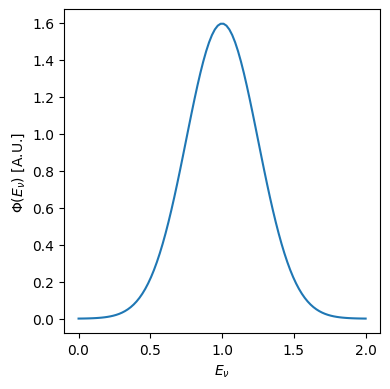

In [54]:
from scipy.stats import norm

enu_dist = norm(1,0.25).pdf
enus = np.linspace(0,2,100)

plt.plot(enus,enu_dist(enus))
plt.ylabel(r"$\Phi(E_\nu)$ [A.U.]")
plt.xlabel(r"$E_\nu$")
plt.show()

If we were in the framework game, we'd write an MC sampling function that works for an arbitrary number of axes, but lets keep it simple and just expand the one we have to the two dimensions that we need. The details of the rejection sampling in multiple dimensions are exactly the same. 

**N.B.** A common pitfall when sampling functions like this is to throw along the first dimension, $E_\nu$, and then based on that random choice, pick a throw range for the second dimension, $Q^2$, based on some known kinematic constraints. This seems like an optimisation: if we know we will be choosing a given enu, why would we pick an invalid $Q^2$? Unfortunately, the simplistic rejection sampling formalism requires a hyper-rectangular throw volume, and this 'optimisation' breaks that assumption. Importance sampling, which is a small extension to rejection sampling, would enable such an optimisation.

In [56]:
def rejsample2D(f, f1domain, f2domain, frange, nsamples, blocksize=1000):

    x1samples = np.array([])
    x2samples = np.array([])
    fvals = np.array([])
    fvals2 = np.array([])
    ntries = 0

    while len(x1samples) < nsamples:
        #to make the best use of numpy vectorisation we will
        #  work in blocks until we have at least enough samples
        x1 = uniform.rvs(f1domain[0],f1domain[1] - f1domain[0], size=blocksize)
        x2 = uniform.rvs(f2domain[0],f2domain[1] - f2domain[0], size=blocksize)
        
        fx = f(x1,x2)
        y = uniform.rvs(frange[0], frange[1] - frange[0], size=blocksize)

        accepted = y < fx
    
        x1samples = np.append(x1samples, x1[accepted])
        x2samples = np.append(x2samples, x2[accepted])
        
        fvals = np.append(fvals, fx)
        fvals2 = np.append(fvals2, fx**2)
        ntries = ntries + blocksize

    return x1samples[0:nsamples], x2samples[0:nsamples], \
            fvals.mean() * (f1domain[1] - f1domain[0]) * (f2domain[1] - f2domain[0]), \
            np.sqrt((fvals2.mean() - fvals.mean()**2)/(ntries-1)), \
            ntries

lets look at the function in 2D to get some intuition about its shape. First, lets define a factory function that lets us create an event rate function with the flux mean and width, and the neutrino species pre-selected.

In [57]:
def MakeToyGausFluxXS(flux_mean, flux_width, nupid):
    enu_dist = norm(flux_mean, flux_width).pdf
    def ToyGausFluxXS(enu, Q2):
        return LSQEDSigmaDQ2Physical_pb(enu, Q2, nupid) * enu_dist(enu)
    return ToyGausFluxXS

then we can draw the function surface and see what we're dealing with

In [58]:
from matplotlib import cm

nupid = 14
enus = np.linspace(0,2,25)
Q2s = np.linspace(*AllowedQ2Range(2, nupid), 25)
enus, Q2s = np.meshgrid(enus, Q2s)

evrate = MakeToyGausFluxXS(1, 0.25, 14)

phidsdQ2 = evrate(enus, Q2s)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot_surface(enus, Q2s, phidsdQ2, cmap=cm.Blues)
ax.set_xlabel(r"$E_\nu$ [GeV]")
ax.set_ylabel(r"$Q^2$ [GeV$^2$]")
ax.set_zlabel(r"$\Phi(E_\nu)\frac{\text{d}\sigma}{\text{d}Q^2}(E_\nu,Q^2)$ [A.U.]")

plt.show()

ValueError: 
\Phi(E_\nu)\frac{\text{d}\sigma}{\text{d}Q^2}(E_\nu,Q^2)
                 ^
ParseSyntaxException: Unknown symbol: \text, found '\'  (at char 17), (line:1, col:18)

<Figure size 400x400 with 1 Axes>

It looks like a simple, single-peaking function so we can find the maximum as before and then sample.

500000 500000
Total cross section for 1 GeV muon neutrinos from MC integration: 0.00938 +/- 9.59764e-07 [A.U.]
Sampling efficiency = 0.27 %


/tmp/ipykernel_390424/1476626153.py:27: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Total cross section for 1 GeV muon neutrinos from spi.dblquad integration: 0.00942 +/- 6.43867e-04 [A.U.]


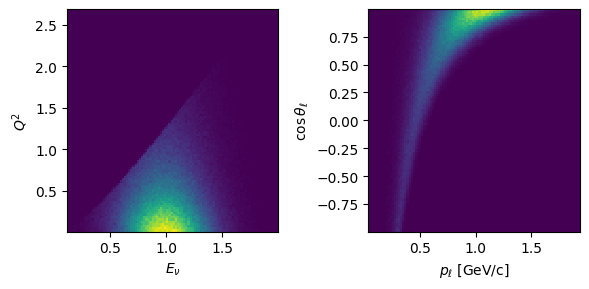

In [61]:
nupid = 14

evrate = MakeToyGausFluxXS(1, 0.25, 14)

q2r = AllowedQ2Range(2, nupid)

result = opt.differential_evolution(lambda x: -evrate(*x), [(0,2), q2r])
max_func_val = -result.fun * 2

EnuSamples, Q2Samples, sigint, error, ntries = \
    rejsample2D(evrate, (0,2), q2r, (0, max_func_val), 500000, 100000)

events = PhysicalKinematicsBlob(EnuSamples, Q2Samples, nupid)

print(len(events.physical), events.physical.sum())

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(6,3))

ax1.hist2d(EnuSamples, Q2Samples, bins=100)
ax1.set_ylabel(r"$Q^2$")
ax1.set_xlabel(r"$E_\nu$")

ax2.hist2d(events.plep[events.physical], events.lepct[events.physical], bins=100)
ax2.set_ylabel(r"$\cos{\theta_\ell}$")
ax2.set_xlabel(r"$p_\ell$ [GeV/c]")

fig.show()

print("Total cross section for 1 GeV muon neutrinos from MC integration: %.5f +/- %.5e [A.U.]" % (sigint, error))
print("Sampling efficiency = %.2f %%" % (100 * 50000/ntries))

dblquadi, errori = spi.dblquad(lambda Q2, E_nu_GeV: LSQEDSigmaDQ2Physical_pb(E_nu_GeV, Q2, nupid)* enu_dist(E_nu_GeV), 0, 2, 
            lambda E_nu_GeV: AllowedQ2Range(E_nu_GeV, nupid)[0], 
            lambda E_nu_GeV: AllowedQ2Range(E_nu_GeV, nupid)[1], epsabs=1e-3, epsrel=1e-3)

print("Total cross section for 1 GeV muon neutrinos from spi.dblquad integration: %.5f +/- %.5e [A.U.]" % (dblquadi, errori))

integrators agree on a simple multivariate though, even while they disagree vehemently on the problem I want them to solve

In [52]:
_, _, sigint, ntries = \
    rejsample2D(lambda x, y: np.sin(x) * np.sin(y), (0,pi),(0,pi), (0,1), 500000, 100000)
print("Total from MC integration: %.3f [A.U.]" % sigint)

dblquadi = spi.dblquad(lambda x, y: np.sin(x) * np.sin(y), 0, pi, 
            lambda x: 0, 
            lambda x: pi)[0]

print("Total from spi.dblquad integration: %.3f [A.U.]" % dblquadi)

Total from MC integration: 4.002 [A.U.]
Total from spi.dblquad integration: 4.000 [A.U.]


### Factorising the problem

The statistically correct choosing of interacting neutrino energies and the choosing of kinematics for those interacting energies can be factorised with some pre-calculation. We have already actually done this pre-calculation.

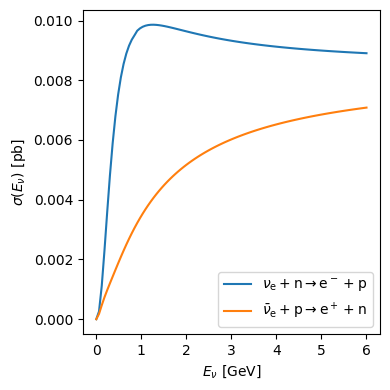

In [53]:
enus = np.linspace(0,6,100)
sig_numu = [LSQESigmaPhysical(enu,12) for enu in enus]
sig_numubar = [LSQESigmaPhysical(enu,-12) for enu in enus]

plt.plot(enus,sig_numu,label=r"$\nu_\text{e} + \text{n} \rightarrow \text{e}^- + \text{p}$")
plt.plot(enus,sig_numubar,label=r"$\bar{\nu}_\text{e} + \text{p} \rightarrow \text{e}^+ + \text{n}$")
plt.ylabel(r"$\sigma(E_\nu)$ [pb]")
plt.xlabel(r"$E_\nu$ [GeV]")
plt.legend()
plt.show()

In [54]:
def MakeToyGausFluxEventRate(flux_mean, flux_width, nupid):
    enu_dist = norm(flux_mean, flux_width).pdf
    enu_knots = np.linspace(0,flux_mean + 10*flux_width, 1000)
    totxs = np.array([LSQESigmaPhysical(enu, 12) for enu in enu_knots])
    def ToyGausFluxEventRate(enu):
        return np.interp(enu, enu_knots, totxs) * enu_dist(enu)
    return ToyGausFluxEventRate

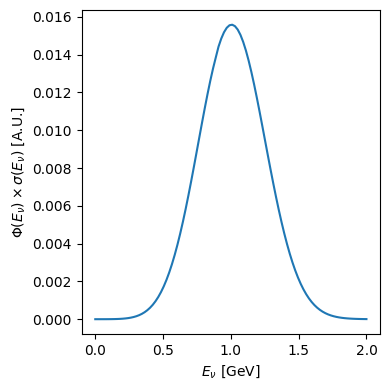

In [55]:
nupid = 14
enus = np.linspace(0,2,100)

precalculated_EventRate = MakeToyGausFluxEventRate(1, 0.25, 14)

plt.plot(enus, precalculated_EventRate(enus))
plt.xlabel(r"$E_\nu$ [GeV]")
plt.ylabel(r"$\Phi(E_\nu)\times \sigma(E_\nu)$ [A.U.]")
plt.show()

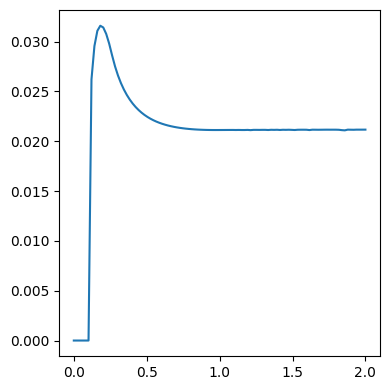

100000 100000
Total cross section for 1 GeV muon neutrinos from MC integration: 0.00952 [A.U.]
Sampling efficiency = 14.29 %
Total cross section for 1 GeV muon neutrinos from spi.quad integration: 0.00952 [A.U.]


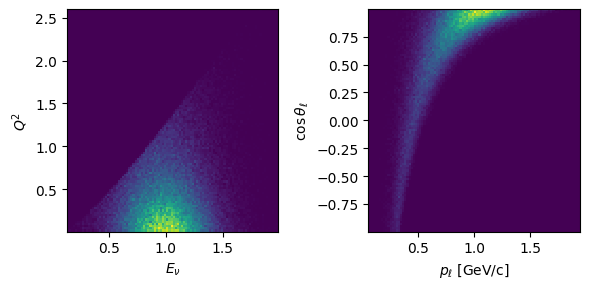

In [64]:
nupid = 14

q2r = AllowedQ2Range(2, nupid)

result = opt.differential_evolution(lambda x: -precalculated_EventRate(*x), [(0,2),])
max_func_val = -result.fun

EnuSamples, sigint, ntries = \
    rejsample1D(precalculated_EventRate, (0,2), (0, max_func_val), 100000, 50000)


## this is an obscenely inefficient way of doing it but I can't think of anything better
enus = np.linspace(0,2,100)
maxdiffs = [ -opt.differential_evolution(lambda Q2 : -LSQEDSigmaDQ2Physical_pb(enu, Q2, nupid), [AllowedQ2Range(enu, nupid),]).fun*1.2 for enu in enus]

plt.plot(enus,maxdiffs)
plt.show()

Q2Samples = \
    np.array([ 
        rejsample1D(lambda Q2 : LSQEDSigmaDQ2Physical_pb(enu, Q2, nupid), 
                    AllowedQ2Range(enu, nupid), 
                    (0, np.interp(enu, enus, maxdiffs)), 
                    1, 1)[0][0] for enu in EnuSamples ])

# print(EnuSamples, Q2Samples)


events = PhysicalKinematicsBlob(EnuSamples,Q2Samples, nupid)

print(len(events.physical), events.physical.sum())

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(6,3))

ax1.hist2d(EnuSamples, Q2Samples, bins=100)
ax1.set_ylabel(r"$Q^2$")
ax1.set_xlabel(r"$E_\nu$")

ax2.hist2d(events.plep[events.physical], events.lepct[events.physical], bins=100)
ax2.set_ylabel(r"$\cos{\theta_\ell}$")
ax2.set_xlabel(r"$p_\ell$ [GeV/c]")

fig.show()

print("Total cross section for 1 GeV muon neutrinos from MC integration: %.5f [A.U.]" % sigint)
print("Sampling efficiency = %.2f %%" % (100 * 50000/ntries))

quadi = spi.quad(lambda E_nu_GeV: precalculated_EventRate(E_nu_GeV), 0, 2,)[0]

print("Total cross section for 1 GeV muon neutrinos from spi.quad integration: %.5f [A.U.]" % quadi)

# The Event Generator

flux rej-sampling, coupled/weighted/pre-calc totxs

## The First Test: Bubble Chamber Predictions

Add ANL flux and event rate and total cross section

# Supplementary Materials

## Kinematic Limits in $Q^2$

We know the kinematic limit occurs at $\cos{\theta_\ell} = -1$ and would like to derive an expression for the limits in $Q^2$ given an input $E_\nu$.

Starting with parts derived [earlier](#Kinematics-Calculation): <br>
[4] $\cos{\theta_\ell} = (E_\nu^2 + p_\ell^2 - p_{N^\prime}^2)/(2E_\nu p_\ell)$ <br>
[5] $Q^2 = p_{N^\prime}^2 - q_0^2$<br>
[8] $q_0 = (Q^2 - (M_N^2 - M_{N^\prime}^2))/2M_N$

We want to express [4] only in $Q^2$. 

First we try and elminate the $p_\ell^2 - p_{N^\prime}^2$ term: <br>
$p_\ell^2 = E_\nu^2 + q_0^2 -2E_\nu q_0 - m_\ell^2$ <br>
including [5]: $p_\ell^2 - p_{N^\prime}^2 = E_\nu^2 + \cancel{q_0^2} -2E_\nu q_0 - m_\ell^2 - Q^2 - \cancel{q_0^2}$ <br>
include [8]: $\rightarrow E_\nu^2 - m_\ell^2 - Q^2 - E_\nu / M_N (Q^2 - \Delta{M^2})$ <br>
where $\Delta{M^2} = (M_N^2 - M_{N^\prime}^2)$ <br>
Collecting powers of $Q^2$: $p_\ell^2 - p_{N^\prime}^2 = E_\nu^2 - m_\ell^2 + \Delta{M^2} E_\nu / M_N  - (1 + E_\nu / M_N) Q^2$

Substituting this into [4] we are left with:<br>
$p_\ell \cos{\theta_\ell} = \underbrace{(2E_\nu^2 - m_\ell^2 + \Delta{M^2} E_\nu / M_N)/2E_\nu}_{C} - \underbrace{((1 + E_\nu / M_N )/2E_\nu)}_{B} Q^2 $

Setting $\cos{\theta_\ell} = -1$ and squaring we find: <br>
[S.1] $p_\ell^2 = C^2 - 2BCQ^2 + B^2Q^4$ <br>
Expanding $p_\ell^2$ and substituting [8] we find: <br>
$p_\ell^2 = E_\nu^2 + q_0^2 - 2E_\nu q_0 - m_\ell^2$ <br>
[S.2] $\rightarrow E_\nu^2 - m_\ell^2 + \left(Q^4 + [\Delta{M^2}]^2 - 2 Q^2 \Delta{M^2}\right)/4M_N^2 - E_\nu/M_N\left(Q^2 - \Delta{M^2}\right)$

Combining [S.1] and [S.2] and collecting powers of $Q^2$ we find: <br>
[S.3] $\underbrace{\left(B^2 - 1/4M_N^2\right)}_{a}Q^4 + \underbrace{\left(\Delta{M^2}/2M_N^2 + E_\nu/M_N - 2BC\right)}_{b}Q^2 + \underbrace{\left(C^2 - E_\nu^2 + m_\ell^2 - [\Delta{M^2}]^2/4M_N^2 - E_\nu \Delta{M^2}/M_N\right)}_{c} = 0$ <br>
which we can solve with the usual quadratic formula:
$Q^2 = \left(-b \pm \sqrt{b^2 - 4ac}\right)/2a$ <br>
with, after some simplification of [S.3] and multiplying through by $4E_\nu^2$, we identify: <br>
$a = 1 + 2E_\nu/M_N$ <br>
$b = -2\left(2E_\nu^2 - \left[1 + E_\nu/M_N\right] m_\ell^2 + E_\nu\Delta{M^2}/M_N\right)$ <br>
$c = m_\ell^4 - 2m_\ell^2 \Delta{M^2} E_\nu /M_N $ <br>

This allows us to identify the kinematically allowed range of $Q^2$ for any $E_\nu$

### References and Further Reading

https://indico.fnal.gov/event/59963/contributions/288525/attachments/176698/240246/kniewczas_240412.pdf#page=24